In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import yaml
# import roboticstoolbox as rtb

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from ipywidgets import interact, widgets


from assistive_arm.utils.data_preprocessing import prepare_opencap_markers

## Read data

### Marker data

In [3]:
subject = "subject_1"
subject_data = Path("/Users/xabieririzar/Desktop/Life/Studium/TUM/M.Sc Robotics/Masterarbeit Harvard/Thesis/Subject testing/Subject data/") / subject
trial = subject_data / "trial_2"

project_moco_data = Path("/Users/xabieririzar/uni-projects/Harvard/assistive-arm/moco/")
control_solutions = project_moco_data / "control_solutions"

# Set directories
opencap_markers = pd.read_csv(trial / "opencap_tracker.trc", delimiter="\t", skiprows=3).tail(-1)
filtered_markers = prepare_opencap_markers(opencap_markers)

# Read solution and yaml config
solution_path = control_solutions / "opencap_simple_assistance_false_2023-09-22_17-13.sto"
control_solution = pd.read_csv(solution_path, delimiter="\t", skiprows=18)
config_path = control_solutions / f"{solution_path.stem}.yaml"

try:
    with open(config_path, "r") as f:
        config_file = yaml.load(f, Loader=yaml.FullLoader)
except FileNotFoundError:
    print(f"No config file found at {config_path}")


No config file found at /Users/xabieririzar/uni-projects/Harvard/assistive-arm/moco/control_solutions/opencap_simple_assistance_false_2023-09-22_17-13.yaml


### Get pelvis marker and set it as human anchoring position

In [4]:
pelvis_x = (filtered_markers["r.PSIS_study"].X + filtered_markers["L.PSIS_study"].X)/2 
pelvis_y = (filtered_markers["r.PSIS_study"].Y + filtered_markers["L.PSIS_study"].Y)/2 
pelvis_z = (filtered_markers["r.PSIS_study"].Z + filtered_markers["L.PSIS_study"].Z)/2 

pelvis_marker = pd.DataFrame({"Time": filtered_markers.Time.t, "X": pelvis_x, "Y": pelvis_y, "Z": pelvis_z})
pelvis_marker = pelvis_marker[(pelvis_marker.Time >= 1.8) & (pelvis_marker.Time <= 3.2)].reset_index(drop=True)
pelvis_marker.set_index("Time", inplace=True)
new_index = pd.Index(np.arange(pelvis_marker.index.min(), pelvis_marker.index.max() + 0.025, step=0.025), name="Time")
pelvis_marker_aligned = pelvis_marker.reindex(new_index, method="nearest")


### Read assistive force profile

In [5]:
assistive_force = control_solution[["time", "/forceset/reserve_jointset_ground_pelvis_pelvis_tx", "/forceset/reserve_jointset_ground_pelvis_pelvis_ty"]]
assistive_force.set_index("time", inplace=True)
assistive_force.columns = ["X", "Y"]
assistive_force.insert(2, "Z", 0)
assistive_force *= 100
assistive_force *= 0.6666

## Calculate optimal link length ratio

### Get distance vector from pelvis to anchor point

In [6]:
chair_position = np.array([-0.6, 0.5, -0.075])
pelvis_to_chair = chair_position - pelvis_marker_aligned

print("Anchoring point on bench: ", pelvis_to_chair.X.iloc[0])

Anchoring point on bench:  -0.24704335


### Calculate optimal length

In [7]:
def get_rotation_matrix(degrees: float) -> np.array:
    return np.array([
            [np.cos(np.deg2rad(degrees)), -np.sin(np.deg2rad(degrees)), 0],
            [np.sin(np.deg2rad(degrees)), np.cos(np.deg2rad(degrees)), 0],
            [0, 0, 1]
        ])

def compute_torque_profiles(l1: float, l2: float, F: pd.DataFrame, position: pd.DataFrame, elbow_up: bool=True):
    """ Compute the torque at the shoulder joint given the position of the end effector and the force applied to it.

    Args:
        l1 (float): length of the first link
        l2 (float): length of the second link
        position (N, 3): dataframe with the position of the end effector over time
        elbow_up (int, optional): 1 if the elbow is up, -1 if the elbow is down. Defaults to 1.

    Returns:
        np.array: torque array
    """
    N = position.shape[0]

    # Rotate EE position to robot frame
    rotate_ee = get_rotation_matrix(-90)
    pos_rot = (rotate_ee @ position.T).T # We apply the transpose to get the correct shape
    pos_rot.columns = ["X", "Y", "Z"]

    arccos_argument = (pos_rot.X**2 + pos_rot.Y**2 - l1**2 - l2**2) / (2 * l1 * l2)
    if np.any(arccos_argument > 1) or np.any(arccos_argument < -1):
        return np.nan, np.nan
    
    theta_2 = np.arccos(arccos_argument)#*(1 if elbow_up else -1)
    theta_1 = np.arctan2(pos_rot.Y, pos_rot.X) - np.arctan2(l2 * np.sin(theta_2), l1 + l2*np.cos(theta_2))

    jacobian = np.array([
        [-l1*np.sin(theta_1)-l2*np.sin(theta_1+theta_2), -l2*np.sin(theta_1+theta_2)],
        [l1*np.cos(theta_1)+l2*np.cos(theta_1+theta_2), l2*np.cos(theta_1+theta_2)],
        np.ones((2, N))
    ])
    jacobian = np.transpose(jacobian, (2, 0, 1)) # Bring jacobian to correct shape
    # Force vector in robot frame, negate because we want to push
    rotate_forces = get_rotation_matrix(90)
    F_rot = -(rotate_forces @ F.T).T.to_numpy()
    F_rot = F_rot[:, :-1] # remove Z component
    
    # Build force and torque vector (N, 3, 1))
    torque = np.cross(pos_rot, F_rot)[:, -1].reshape(N, 1)
    F_tot = np.concatenate((F_rot, torque), axis=1).reshape(N, 3, 1)

    torque = (jacobian.transpose((0, 2, 1)) @ F_tot).squeeze()
    joint_angles = pd.concat((theta_1, theta_2), axis=1)
    joint_angles.columns = ["theta_1", "theta_2"]

    return torque, joint_angles

In [8]:
# 5 cm safety margin
min_necessary_length = np.linalg.norm(pelvis_to_chair, axis=1).max()

print("Minimum total length: ", min_necessary_length)

resolution = 30
link_lengths_1 = np.linspace(0.1, 1, resolution)
link_lengths_2 = np.linspace(0.1, 1, resolution)

# Set joint angle limits (degrees)
theta_1_lims = np.deg2rad([0, 180])
theta_2_lims = np.deg2rad([-145, 145])

results = []

for l1 in link_lengths_1:
    for l2 in link_lengths_2:
        if l1 + l2 < min_necessary_length:
            continue
               
        torques, joint_angles = compute_torque_profiles(l1, l2, F=assistive_force, position=pelvis_to_chair)

        if np.any(np.isnan(torques)) or np.any(np.isnan(joint_angles)):
            continue
        result = {
            'l1': l1,
            'l2': l2,
            'tau_1': torques[:, 0],
            'tau_2': torques[:, 1],
            'theta_1': joint_angles.theta_1,
            'theta_2': joint_angles.theta_2,
        }
        results.append(result)

Minimum total length:  0.8402363059070971


In [9]:
link_length_torque_profiles = pd.DataFrame(results)
link_length_torque_profiles.dropna(inplace=True)

In [10]:
# Filter out solutions that are outside of the joint angle limits
def check_theta(series, theta_lims):
    return series.apply(lambda x: theta_lims[0] <= x <= theta_lims[1]).all()

link_length_torque_profiles = link_length_torque_profiles[link_length_torque_profiles["theta_1"].apply(check_theta, theta_lims=theta_2_lims) & link_length_torque_profiles["theta_2"].apply(check_theta, theta_lims=theta_2_lims)]

In [11]:
link_length_torque_profiles

,l1,l2,tau_1,tau_2,theta_1,theta_2
12,0.410345,0.441379,"[1.3529134657538249, -10.956327398157889, -22....","[1.1939362659220396, -4.895721211989825, -10.3...",Time 1.800 0.608432 1.825 0.598828 1.850...,Time 1.800 2.504841 1.825 2.507230 1.850...
20,0.441379,0.410345,"[1.3529134657538244, -10.956327398157889, -22....","[0.9454205605891531, -2.868694002167842, -6.00...",Time 1.800 0.828646 1.825 0.819922 1.850...,Time 1.800 2.504841 1.825 2.507230 1.850...


In [12]:
# Get ideal torque combination
peak_torques = link_length_torque_profiles[["tau_1", "tau_2"]].map(lambda x: np.abs(x).max())
min_overall_torque = np.linalg.norm(peak_torques, axis=1)
min_torque_loc = min_overall_torque.argmin()
ideal_torque = peak_torques.iloc[min_torque_loc]

In [13]:
l1, l2, tau_1, tau_2, theta_1, theta_2 = link_length_torque_profiles.iloc[min_torque_loc]

In [14]:
# Calculate ideal bar length based on offset from rotational axis and link inserts
bar_1 = l1 - 0.103
bar_2 = l2 - 0.081125
print(f"Bar 1: {bar_1:.3f} m")
print(f"Bar 2: {bar_2:.3f} m")

Bar 1: 0.338 m
Bar 2: 0.329 m


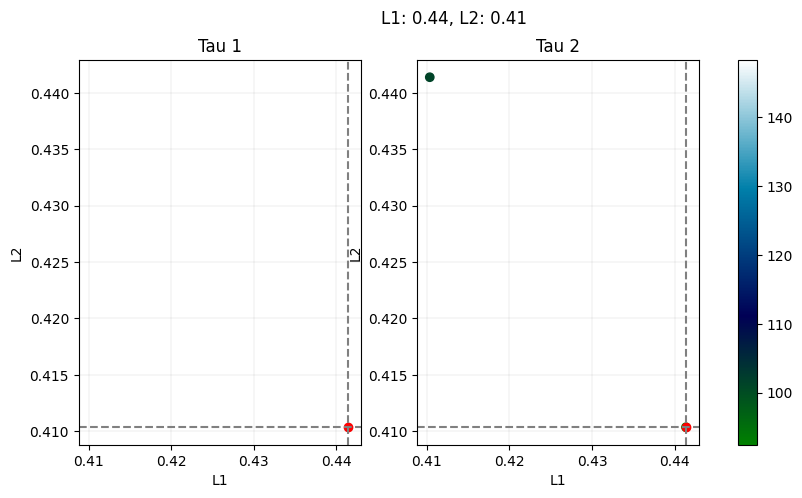

In [15]:
cNorm  = colors.Normalize(vmin=np.min([peak_torques.tau_1.min(), peak_torques.tau_2.min()]), vmax=np.max([peak_torques.tau_1.max(), peak_torques.tau_2.max()]))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap="ocean")

highlight = (l1, l2)
highlight_label = f"({l1:.2f}, {l2:.2f})"

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle(f"L1: {l1:.2f}, L2: {l2:.2f}")

sc1 = axs[0].scatter(link_length_torque_profiles.l1, link_length_torque_profiles.l2, c=scalarMap.to_rgba(peak_torques.tau_1))
axs[0].scatter(*highlight, color='red')
axs[0].axvline(x=highlight[0], linestyle="--", color='grey')  # adding vertical line
axs[0].axhline(y=highlight[1], linestyle="--", color='grey')
axs[0].grid(color='black', linestyle='-', linewidth=0.1, alpha=0.5)
axs[0].set_xlabel("L1")
axs[0].set_ylabel("L2")
axs[0].set_title("Tau 1")


sc2 = axs[1].scatter(link_length_torque_profiles.l1, link_length_torque_profiles.l2, c=scalarMap.to_rgba(peak_torques.tau_2))
axs[1].scatter(*highlight, color='red')
axs[1].axvline(x=highlight[0], linestyle="--", color='grey')  # adding vertical line
axs[1].axhline(y=highlight[1], linestyle="--", color='grey')
axs[1].grid(color='black', linestyle='-', linewidth=0.1, alpha=0.5)
axs[1].set_xlabel("L1")
axs[1].set_ylabel("L2")
axs[1].set_title("Tau 2")

fig.colorbar(scalarMap, ax=axs.ravel().tolist())

plt.show()

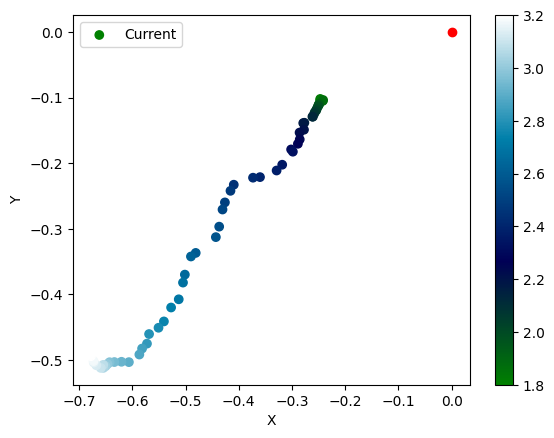

In [16]:
rotate_90 = get_rotation_matrix(90)

P_EE = np.array([l1*np.cos(theta_1) + l2*np.cos(theta_1 + theta_2), l1*np.sin(theta_1) + l2*np.sin(theta_1 + theta_2), np.zeros(theta_1.shape)])
P_L1 = np.array([l1*np.cos(theta_1), l1*np.sin(theta_1), np.zeros(theta_1.shape)])

plt.scatter((rotate_90 @ P_EE)[0], (rotate_90 @ P_EE)[1], c=pelvis_to_chair.index, cmap="ocean", label="Current")
plt.colorbar()
plt.plot(0, 0, "o", c="r")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

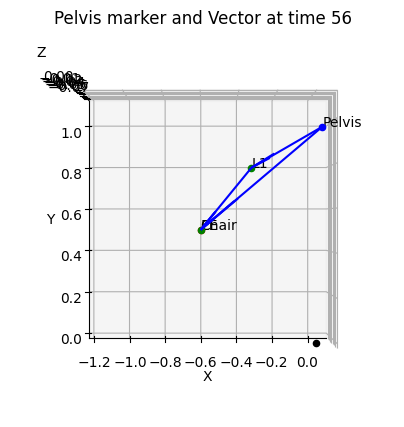

In [17]:
rotate_90 = get_rotation_matrix(90)

timestep = 56
plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')
ax.view_init(azim=-90, elev=90)

pelvis_pos = pelvis_marker_aligned.iloc[timestep]
pelvis_chair = pelvis_to_chair.iloc[timestep].T

l1_vector = rotate_90 @ P_L1.T[timestep, :]
l1_origin = pelvis_pos
l1_pos = pelvis_pos + l1_vector

l2_pos = rotate_90 @ P_EE.T[timestep, :]
l2_origin = l1_pos
l2_vector = l2_pos - l1_vector

ee_pos = pelvis_pos + l2_pos

ax.scatter(*pelvis_pos, color="b")
ax.text(*pelvis_pos, "Pelvis")

ax.scatter(*l1_pos, color="g")
ax.text(*l1_pos, "L1")

ax.scatter(*ee_pos, color="g")
ax.text(*ee_pos, "EE")

ax.scatter(*chair_position, color="r")
ax.text(*chair_position, "Chair")

origin = [0, 0, 0]
ax.scatter(*origin, color="k")

ax.quiver(*pelvis_pos, *pelvis_chair, color="b")
ax.quiver(*l1_origin, *l1_vector, color="b")
ax.quiver(*l2_origin, *l2_vector, color="b")

ax.set_xlim([-1.2, pelvis_marker_aligned.X.max()])
ax.set_ylim([0, 1.1])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Pelvis marker and Vector at time {}'.format(timestep))

plt.show()

In [18]:
# Rad/s to rpm
time_vector = assistive_force.index
theta_1_dot = np.gradient(theta_1) / time_vector.diff()
theta_2_dot = np.gradient(theta_2) / time_vector.diff()

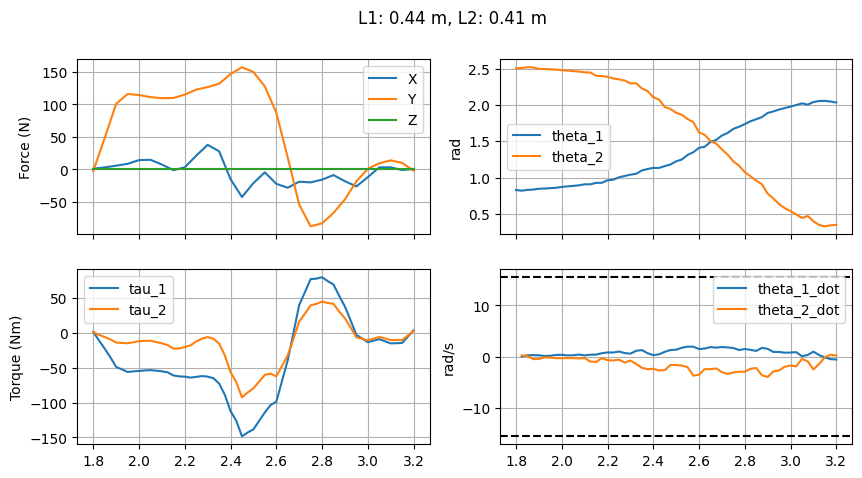

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5), sharex=True)
fig.suptitle(f"L1: {float(l1):.2f} m, L2: {float(l2):.2f} m")
axs[0, 0].plot(time_vector, assistive_force)
axs[0, 0].set_ylabel("Force (N)")
axs[0, 0].legend(["X", "Y", "Z"])
axs[0, 0].grid()

axs[1, 0].plot(time_vector, tau_1, label="tau_1")
axs[1, 0].plot(time_vector, tau_2, label="tau_2")
axs[1, 0].legend()
axs[1, 0].set_ylabel("Torque (Nm)")
axs[1, 0].grid()

axs[0, 1].plot(time_vector, theta_1, label="theta_1")
axs[0, 1].plot(time_vector, theta_2, label="theta_2")
axs[0, 1].legend()
axs[0, 1].set_ylabel("rad")
axs[0, 1].grid()

# Add dashed line for max rad/s with label
axs[1, 1].plot(time_vector, theta_1_dot, label="theta_1_dot")
axs[1, 1].plot(time_vector, theta_2_dot, label="theta_2_dot")
axs[1, 1].axhline(y=15.5, linestyle="--", color="k")
axs[1, 1].axhline(y=-15.5, linestyle="--", color="k")
axs[1, 1].legend()
axs[1, 1].set_ylabel("rad/s")
axs[1, 1].grid()